In [1]:
#import necessary packages
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from tqdm import tqdm  
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import seaborn as sns
#load dataframe
df = pd.read_csv("Reviews.csv")

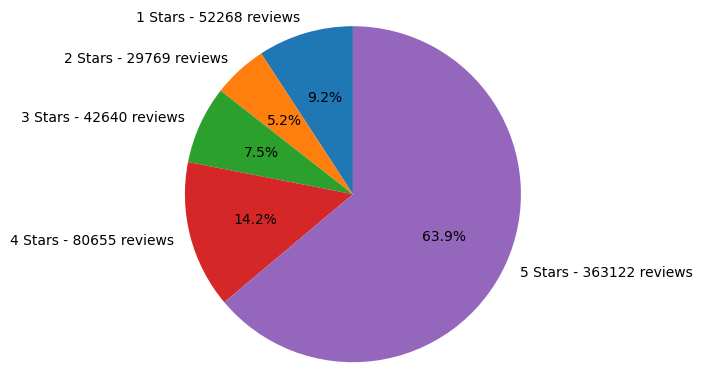

In [2]:
# count of total reviews by percentages

counts = df['Score'].value_counts().sort_index()
plt.pie(counts, labels=[f"{star} Stars - {counts[star]} reviews" for star in counts.index], autopct='%1.1f%%', startangle=90)
    
# Equal aspect ratio ensures that pie is drawn as a circle.
plt.axis('equal')
plt.show()

### Get the overall sentiment of the data

In [3]:
df['sentiment'] = df['Score'].apply(lambda score: 
    'very negative' if score == 1 else
    'negative' if score == 2 else
    'neutral' if score == 3 else
    'positive' if score == 4 else
    'very positive' if score == 5 else 'unknown'
)
print(df['sentiment'])


0         very positive
1         very negative
2              positive
3              negative
4         very positive
              ...      
568449    very positive
568450         negative
568451    very positive
568452    very positive
568453    very positive
Name: sentiment, Length: 568454, dtype: object


### Preproccess the text

In [4]:
# Download NLTK stopwords and initialize the stemmer
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def preprocess_text(text):
    if isinstance(text, str) and len(text) > 0:
        text = text.lower()
        #tokenize the text
        tokens = nltk.word_tokenize(text, preserve_line=True)
        tokens = [word for word in tokens if word.isalnum()]
        #remove stop words and apply the stemmer
        tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
        # Join tokens back into a string
        text = ' '.join(tokens)
        
        return text
    else:
        return ""

[nltk_data] Downloading package stopwords to C:\Users\Tom
[nltk_data]     O'Connor\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
if os.path.exists('cleaned_dataframe.csv'):
    df = pd.read_csv('cleaned_dataframe.csv')
else:
    tqdm.pandas()
    #apply preprocessing to text
    df['cleaned_reviews'] = df['Text'].progress_apply(preprocess_text)
    df.to_csv('cleaned_dataframe.csv', index=False)


In [6]:
np.random.seed(42)
# Set the number of data points you want to randomly select

X = df['cleaned_reviews']
y = df['Score']
#split the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X_train.values
X_test = X_test.values
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()
len(X_train), len(y_train), len(X_test), len(y_test)

(454763, 454763, 113691, 113691)

### Set Device 

In [7]:
device = 'cuda' if torch.cuda.is_available else 'cpu'
device

'cuda'

### Vectorize data

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

### Make model

In [9]:

class SentimentAnalysisModel(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, dropout_rate=0.5):
        super(SentimentAnalysisModel, self).__init__()
        
        # First hidden layer
        self.layer1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(p=dropout_rate)
        
        # Second hidden layer
        self.layer2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(p=dropout_rate)
        
        # Output layer
        self.layer3 = nn.Linear(hidden_size2, output_size)

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        
        x = self.layer2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        
        x = self.layer3(x)
        
        return x


### Make DataLoader

In [10]:
train_data = TensorDataset(torch.from_numpy(X_train_tfidf.toarray()).float(), torch.from_numpy(y_train))
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_data = TensorDataset(torch.from_numpy(X_test_tfidf.toarray()).float(), torch.from_numpy(y_test))
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)

In [11]:
input_size = 5000
hidden_size1 = 512
hidden_size2 = 256
#make output size for star ratings
output_size = 6
model = SentimentAnalysisModel(input_size, hidden_size1, hidden_size2, output_size).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

#### Train and test the model

In [12]:

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_acc = 0
    train_predictions = []
    train_true_labels = []

    for batch, (X, y) in enumerate(tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')):
        X, y = X.to(device), y.to(device, dtype=torch.long)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        y_pred_class = torch.argmax(y_pred, dim=1)
        train_acc += accuracy_score(y.cpu().numpy(), y_pred_class.cpu().numpy())
        train_predictions.extend(y_pred_class.cpu().numpy())
        train_true_labels.extend(y.cpu().cpu().numpy())

    train_f1 = f1_score(train_true_labels, train_predictions, average='weighted')

    model.eval() 
    test_loss, test_acc = 0, 0
    test_predictions = []
    test_true_labels = []
    test_positivity_correct = 0  # Counter for correctly predicted positive sentiments
    
    with torch.inference_mode():
        for batch, (X, y) in enumerate(tqdm(test_loader, desc=f'Test')):
            X, y = X.to(device), y.to(device, dtype=torch.long)
            test_pred = model(X)
            loss = loss_fn(test_pred, y)
            test_loss += loss.item()
            test_pred_labels = test_pred.argmax(dim=1)
            test_acc += accuracy_score(y.cpu().numpy(), test_pred_labels.cpu().numpy())
            test_predictions.extend(test_pred_labels.cpu().numpy())
            test_true_labels.extend(y.cpu().cpu().numpy())
            
            # Check if predicted sentiment is positive
            predicted_positive = (test_pred_labels >= 4)
            true_positive = (y >= 4)
            test_positivity_correct += torch.sum(predicted_positive == true_positive).item()

    test_f1 = f1_score(test_true_labels, test_predictions, average='weighted')
    positivity_accuracy = test_positivity_correct / len(test_loader.dataset)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train_Loss: {train_loss/len(train_loader):.4f}, Train_Acc: {train_acc/len(train_loader):.4f}, Train f1: {train_f1:.4f}, '
          f'Test_Loss: {test_loss/len(test_loader):.4f}, Test_Acc: {test_acc/len(test_loader):.4f}, Test_f1: {test_f1:.4f}, Positivity_Accuracy: {positivity_accuracy:.4f}')



Epoch 1/10:   0%|          | 0/3553 [00:00<?, ?it/s]

Test: 100%|██████████| 889/889 [00:04<00:00, 221.69it/s]


Epoch [1/10], Train_Loss: 0.7854, Train_Acc: 0.7149, Train f1: 0.6666, Test_Loss: 0.7055, Test_Acc: 0.7454, Test_f1: 0.7083, Positivity_Accuracy: 0.8958


Test: 100%|██████████| 889/889 [00:03<00:00, 241.74it/s]


Epoch [2/10], Train_Loss: 0.6620, Train_Acc: 0.7643, Train f1: 0.7383, Test_Loss: 0.6386, Test_Acc: 0.7751, Test_f1: 0.7499, Positivity_Accuracy: 0.9094


Test: 100%|██████████| 889/889 [00:03<00:00, 228.97it/s]


Epoch [3/10], Train_Loss: 0.5559, Train_Acc: 0.8049, Train f1: 0.7890, Test_Loss: 0.6051, Test_Acc: 0.7903, Test_f1: 0.7709, Positivity_Accuracy: 0.9145


Test: 100%|██████████| 889/889 [00:03<00:00, 230.91it/s]


Epoch [4/10], Train_Loss: 0.4760, Train_Acc: 0.8335, Train f1: 0.8230, Test_Loss: 0.5974, Test_Acc: 0.7993, Test_f1: 0.7829, Positivity_Accuracy: 0.9184


Test: 100%|██████████| 889/889 [00:04<00:00, 194.17it/s]


Epoch [5/10], Train_Loss: 0.4163, Train_Acc: 0.8531, Train f1: 0.8458, Test_Loss: 0.6019, Test_Acc: 0.8036, Test_f1: 0.7892, Positivity_Accuracy: 0.9192


Test: 100%|██████████| 889/889 [00:03<00:00, 231.05it/s]


Epoch [6/10], Train_Loss: 0.3721, Train_Acc: 0.8680, Train f1: 0.8625, Test_Loss: 0.6119, Test_Acc: 0.8063, Test_f1: 0.7928, Positivity_Accuracy: 0.9198


Test: 100%|██████████| 889/889 [00:03<00:00, 236.35it/s]


Epoch [7/10], Train_Loss: 0.3352, Train_Acc: 0.8806, Train f1: 0.8767, Test_Loss: 0.6456, Test_Acc: 0.8083, Test_f1: 0.7951, Positivity_Accuracy: 0.9196


Test: 100%|██████████| 889/889 [00:03<00:00, 244.41it/s]


Epoch [8/10], Train_Loss: 0.3050, Train_Acc: 0.8912, Train f1: 0.8884, Test_Loss: 0.6655, Test_Acc: 0.8100, Test_f1: 0.7966, Positivity_Accuracy: 0.9192


Test: 100%|██████████| 889/889 [00:03<00:00, 252.48it/s]


Epoch [9/10], Train_Loss: 0.2804, Train_Acc: 0.9000, Train f1: 0.8978, Test_Loss: 0.6854, Test_Acc: 0.8107, Test_f1: 0.7989, Positivity_Accuracy: 0.9197


Test: 100%|██████████| 889/889 [00:03<00:00, 244.58it/s]

Epoch [10/10], Train_Loss: 0.2573, Train_Acc: 0.9077, Train f1: 0.9061, Test_Loss: 0.7122, Test_Acc: 0.8116, Test_f1: 0.8000, Positivity_Accuracy: 0.9196


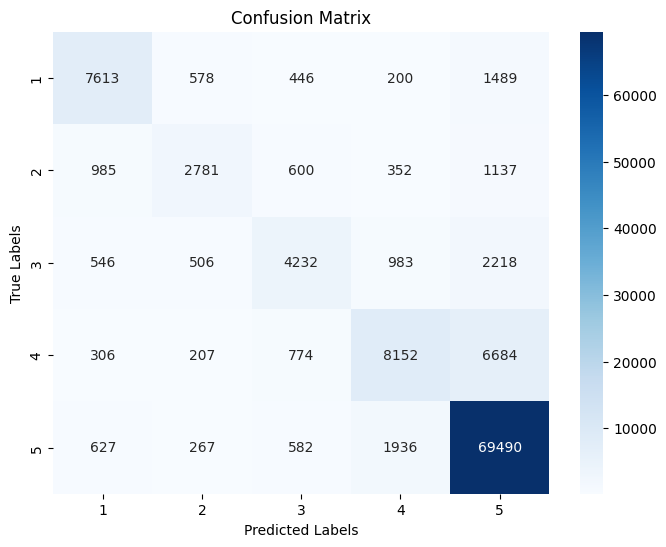

In [13]:
# Set the model to evaluation mode
model.eval()

# Initialize the lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

with torch.inference_mode():
    for batch, (X, y) in enumerate(test_loader):
        X, y = X.to(device), y.to(device, dtype=torch.long)
        test_pred = model(X)
        test_pred_labels = test_pred.argmax(dim=1)

        true_labels.extend(y.cpu().cpu().numpy())
        predicted_labels.extend(test_pred_labels.cpu().numpy())

# Create the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
class_labels = [1, 2, 3, 4, 5]
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


## Save the model

In [17]:
torch.save(model.state_dict(), 'star_pred_model.pth')